# Séries temporais com ARIMA e SARIMAX

## Importações e configurações iniciais

In [1]:
## Bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from numpy import polyfit
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
from sklearn.metrics import explained_variance_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
## Estilos para os gráficos
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (8,4) 
plt.rcParams['axes.grid']=True
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']

## Preparação dos dados

In [3]:
# definindo caminho do arquivo
PATH = "data/df_20181s_20201s_A523.csv"

# escolhendo target
TARGET = "UMD_INS"

# definindo coluna de data
DATE_COLUMN = "date"

# Carregamento dos dados
df = pd.read_csv(PATH)

# Convertendo datas
df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN])

# Selecionando colunas
df = df[[DATE_COLUMN, TARGET]]

# Preenchendo nulos com a média
df = df.fillna(method="ffill")

# Escolha da granularidade (diária)
df = df[[DATE_COLUMN,TARGET]].groupby(DATE_COLUMN).mean()

# Renomeando coluna TARGET
df.columns = ['Y_t']

# normalizando
df['X_t'] = StandardScaler().fit_transform(df['Y_t'].values.reshape(-1, 1))

## EDA

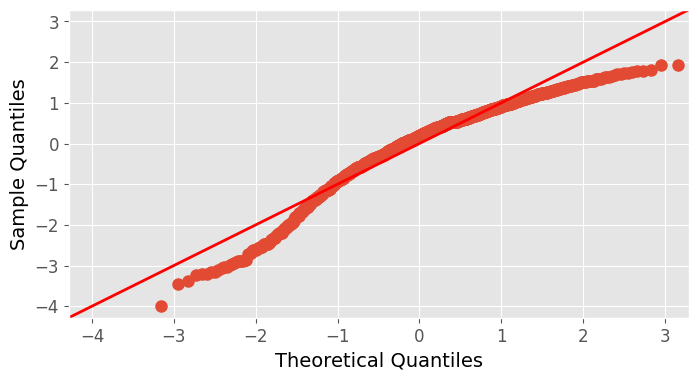

In [4]:
# qqplot de X_t
sm.qqplot(df['X_t'], line='45')
plt.show()

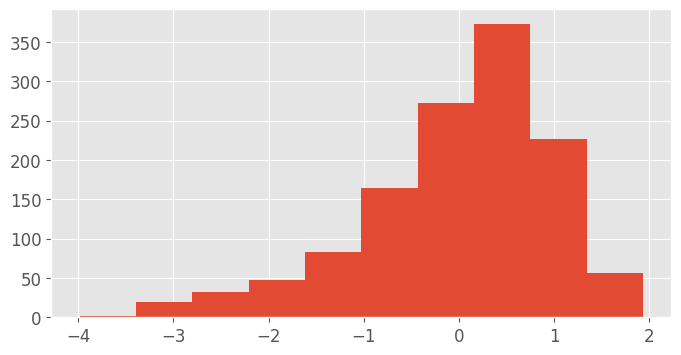

In [5]:
# histograma de X_T
df['X_t'].hist()
plt.show()

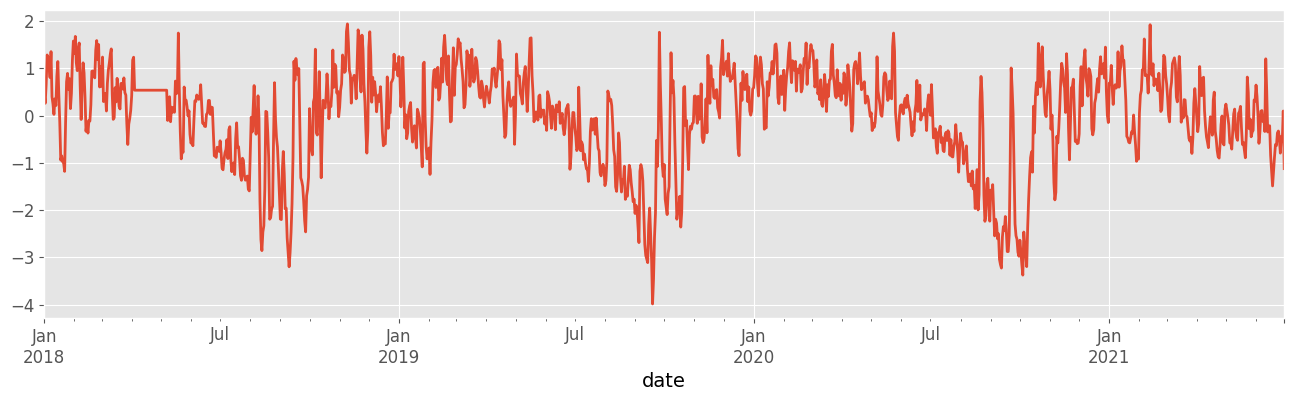

In [6]:
# X_t
df.X_t.plot(figsize=(16,4))
plt.show()

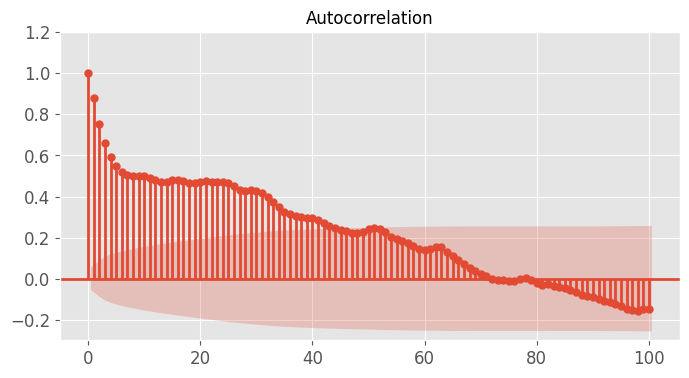

In [7]:
# Autocorrelação de X_t
sm.graphics.tsa.plot_acf(df['X_t'].values.squeeze(), lags=100)
plt.ylim(-0.3,1.2)
plt.show()

$q$ pode ser 40

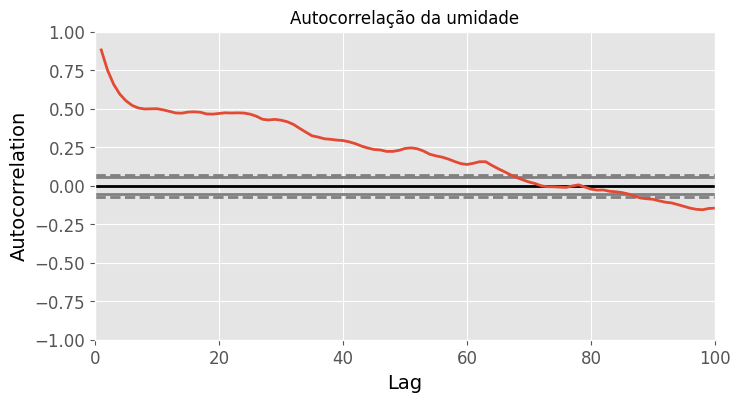

In [8]:
# Autocorrelação parcial de X_t
pd.plotting.autocorrelation_plot(df['X_t'])
plt.title("Autocorrelação da umidade")
plt.grid('on')
plt.xlim(0,100)
plt.show()

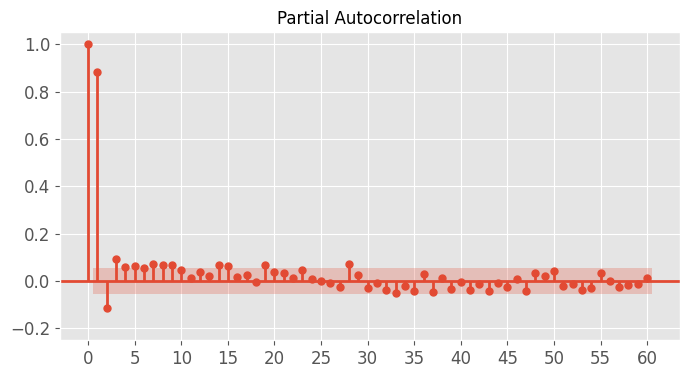

In [9]:
# Autocorrelação parcial de X_t
sm.graphics.tsa.plot_pacf(
    df['X_t'].values.squeeze(), 
    lags=60,
    method='ywm'
)
plt.ylim(-0.25, 1.05)
plt.xticks(list(range(0,61,5)))
plt.show()

Valores do parâmetros $p$ de 1 e 2 parecem ser relevantes, uma vez que distanciam do intervalo de confiança. 

## Diferenciação da série

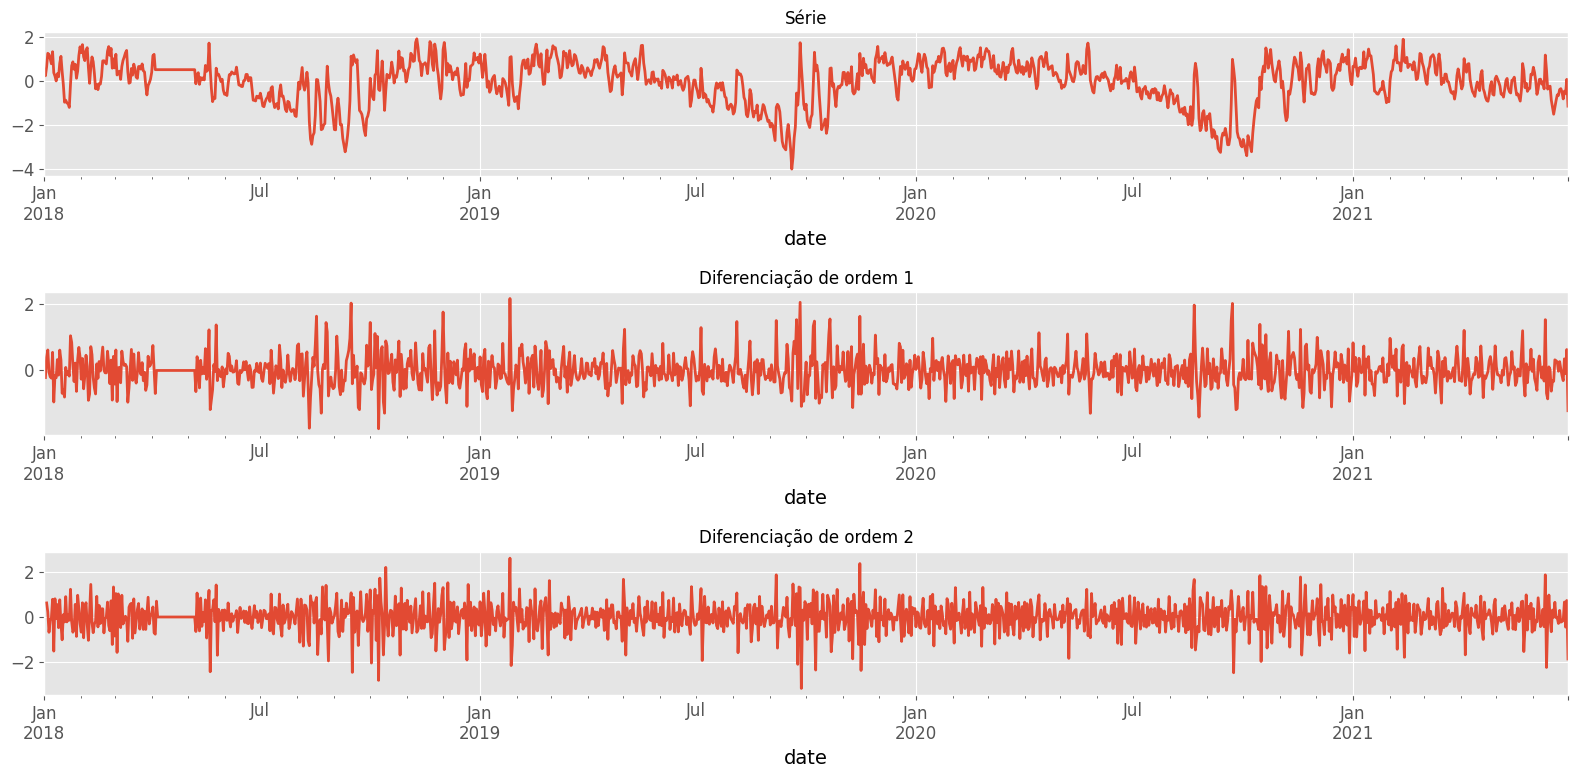

In [12]:
plt.figure(figsize=(16,8))
plt.subplot(3,1,1)
df['X_t'].plot()
plt.title("Série")
plt.subplot(3,1,2)
df['X_t'].diff().plot()
plt.title('Diferenciação de ordem 1')
plt.subplot(3,1,3)
df['X_t'].diff().diff().plot()
plt.title('Diferenciação de ordem 2')
plt.tight_layout()
plt.show()

## É uma série de ruído branco?

*A time series is white noise if the variables are independent and identically distributed with a mean of zero - by Jason Brownlee on March 6, 2017 in Time Series*

- **Predictability:** If your time series is white noise, then, by definition, it is random. You cannot reasonably model it and make predictions.
- **Model Diagnostics:** The series of errors from a time series forecast model should ideally be white noise.

Não é ruído branco se uma ou mais condições acontecem:

- Is the mean/level non-zero?
- Does the mean/level change over time?
- Does the variance change over time?
- Do values correlate with lag values?

O gráfico de autocorrelação mostra um pico no lag 1 fora do intervalo de confiança, portanto não é uma série de ruído branco.

In [13]:
df['X_t'].mean()

-1.1128312228036025e-17

In [14]:
df['X_t'].var()

1.000783699059561

A média muda em diferentes intervalos de tempo:

In [15]:
df['X_t'][500:600].mean()

-0.352182248468625

In [16]:
df['X_t'][600:700].mean()

-0.7873218187660304

In [45]:
import statsmodels.stats.diagnostic as diag
 
diag.acorr_ljungbox(df['X_t'], lags=[40], boxpierce=True, model_df=0, period=None, return_df=None)

(array([11876.5223287]), array([0.]), array([11712.16590725]), array([0.]))

Both p-values are less than 0.01 and so we can say with 99% confidence that the restaurant decibel level time series is not pure white noise.

In [47]:
import statsmodels.stats.diagnostic as diag
 
diag.acorr_ljungbox(df['X_t'].diff().dropna(), lags=[40], boxpierce=True, model_df=0, period=None, return_df=None)

(array([111.11461525]),
 array([1.29668467e-08]),
 array([110.08496445]),
 array([1.8262538e-08]))

### É um random walk

$$X_t = X_{t-1} + (\textit{white noise})$$

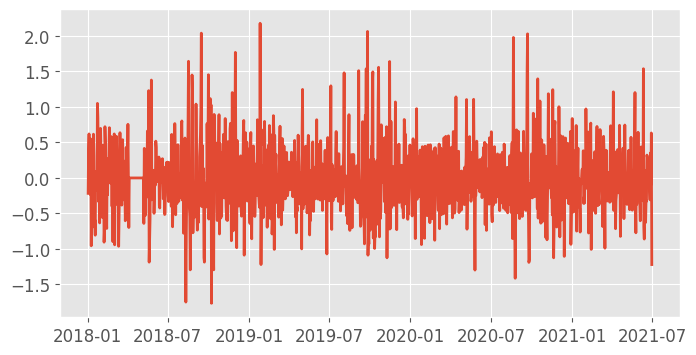

In [31]:
plt.plot(df['X_t'].diff())
plt.show()

In [36]:
df['X_t'].diff().mean()

-0.0012530026373454583

In [35]:
df['X_t'].diff().var()

0.23549739420307253

In [37]:
df['X_t'].diff()[500:600].mean()

-0.026929468969830072

In [38]:
df['X_t'].diff()[600:700].mean()

0.024321205937532075

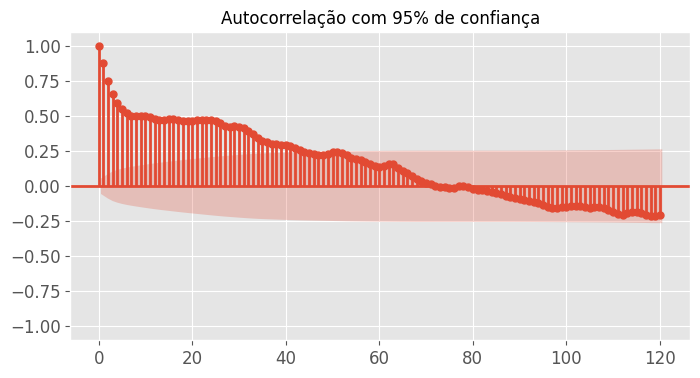

In [44]:
plot_acf(df['Y_t'], lags=120, alpha=0.05, title="Autocorrelação com 95% de confiança")
plt.ylim([-1.1,1.1])
plt.show()

## Decomposição da série

### Na mão

In [166]:
def fit(X, y, degree=3):
    coef = polyfit(X, y, degree)
    trendpoly = np.poly1d(coef)
    return trendpoly(X)

def get_season(s, yearly_periods=4, degree=3):
    X = [i%(365/4) for i in range(0, len(s))]
    seasonal = fit(X, s.values, degree)
    return pd.Series(data=seasonal, index=s.index)

def get_trend(s, degree=3):
    X = list(range(len(s)))
    trend = fit(X, s.values, degree)
    return pd.Series(data=trend, index=s.index)

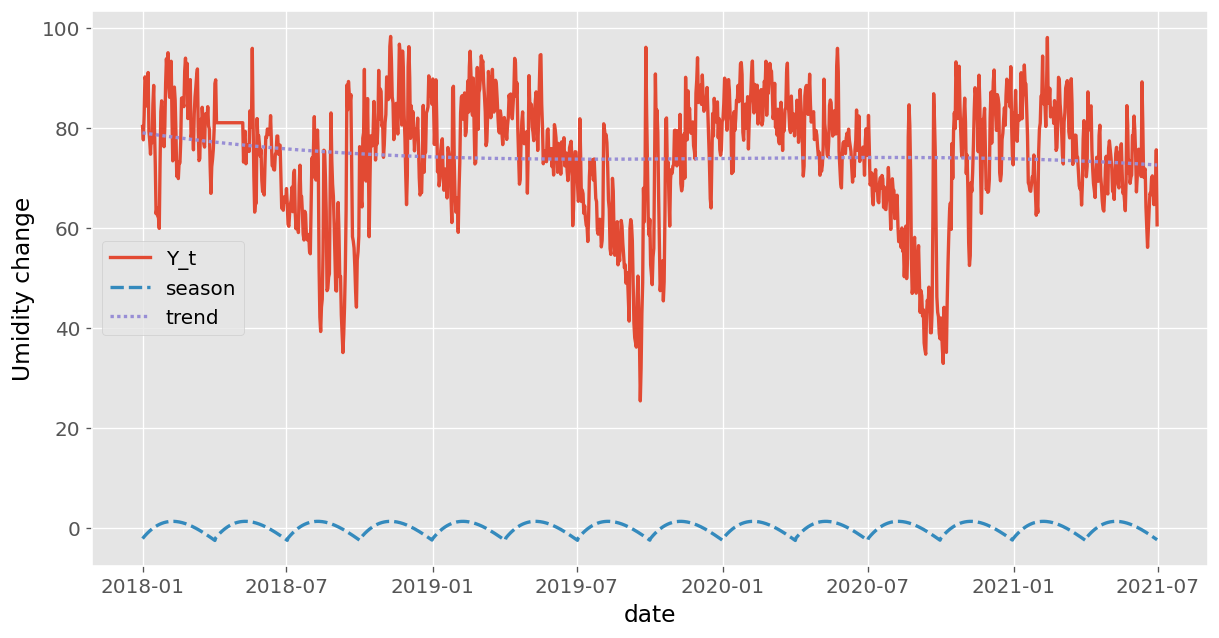

In [169]:
plt.figure(figsize=(12, 6))
df['trend'] = get_trend(df['Y_t'])
df['season'] = get_season(df['Y_t'] - df['trend'])
sns.lineplot(data=df[['Y_t', 'season', 'trend']])
plt.ylabel('Umidity change');
plt.show()

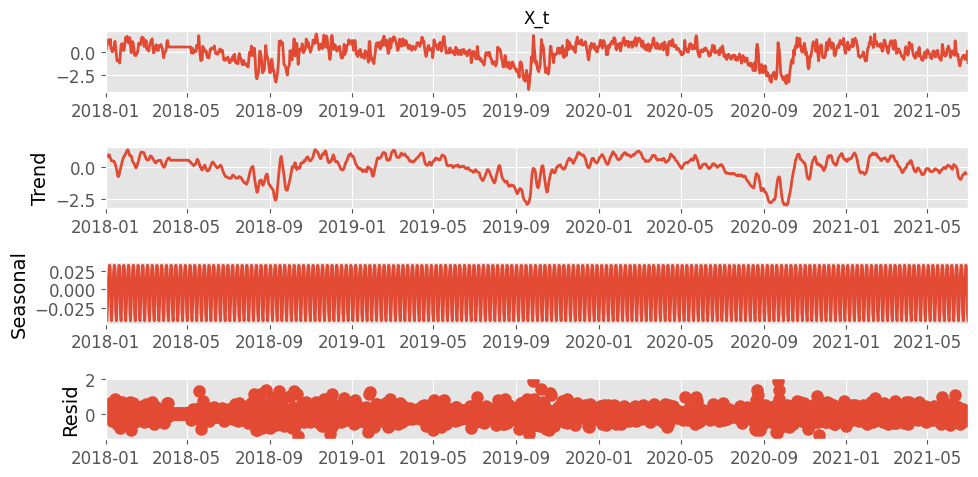

In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

result = seasonal_decompose(df['X_t'], model='additive')
 
rcParams['figure.figsize'] = 10, 5
result.plot()
plt.show()

### Usando Loess 

Robusto a outliers e ajustável a qualquer tipo de sazonalidade.

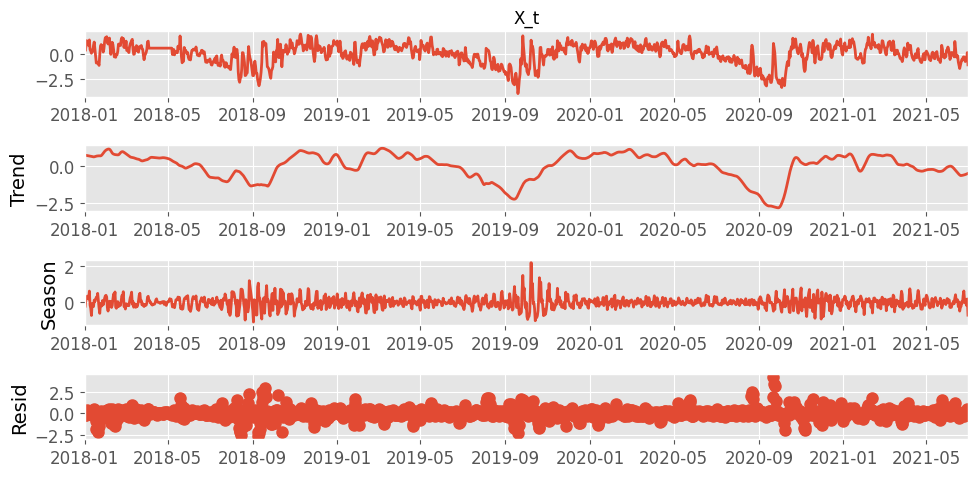

In [60]:
from statsmodels.tsa.seasonal import STL

stl = STL(df['X_t'], period=12, robust=True)
res_robust = stl.fit()
fig = res_robust.plot()

## Teste de estacionariedade

In [159]:
from arch.unitroot import ADF
ADF(df['X_t'].dropna())

Test Statistic,-3.730
P-value,0.004
Lags,14


In [136]:
from arch.unitroot import KPSS
KPSS(df['X_t'])

Test Statistic,0.165
P-value,0.347
Lags,19


In [139]:
result = adfuller(df['X_t'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.730300
p-value: 0.003707


A hipótese nula para o test ADF é que a série temporal não é estacionária.

## Índice de diferenciação

In [13]:
from pmdarima.arima.utils import ndiffs
ndiffs(df['Y_t'], test='adf')

0

## Modelagem com SMA

SMA é a sigla para média móvel simples (simple moving average).

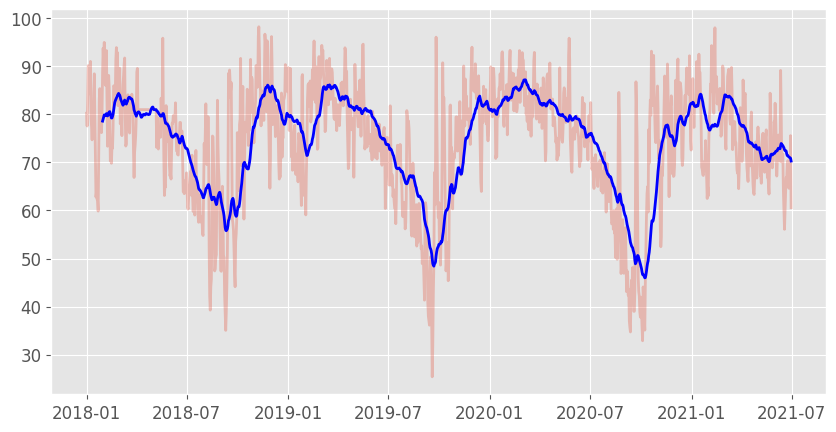

In [115]:
rolling = df['Y_t'].rolling(window=30)
rolling_mean = rolling.mean()
 
# plot the two series
plt.plot(df['Y_t'], alpha=0.3)
plt.plot(rolling_mean, color='blue')
plt.show()

## Modelagem com CMA

CMA é a sigla para center moving average.

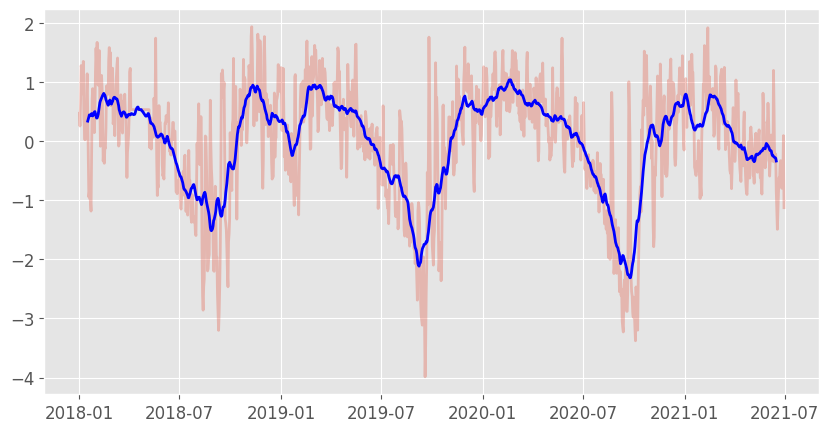

In [67]:
rolling = df['X_t'].rolling(window=30, center=True)
rolling_mean = rolling.mean()

plt.plot(df['X_t'], alpha=0.3)
plt.plot(rolling_mean, color='blue')
plt.show()

## Modelagem com WMA

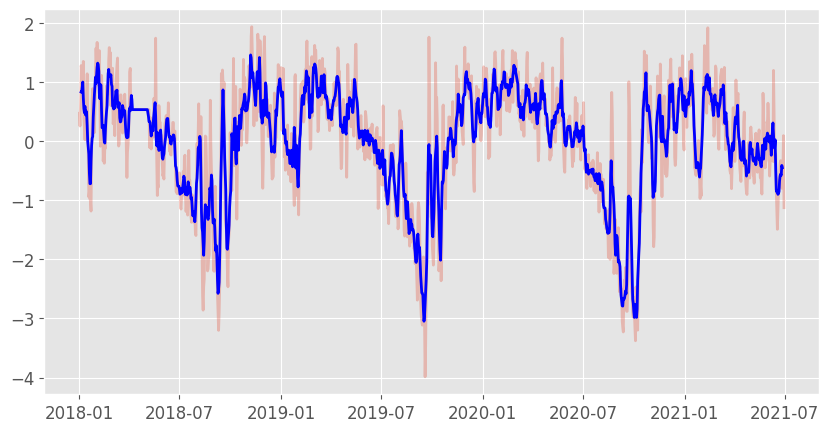

In [72]:
import numpy as np
weights = np.array([0.5, 0.25, 0.10, 0.2, 0.5, 0.3, 0.2])
sum_weights = np.sum(weights)

df['WMA'] = df['X_t'].rolling(window=len(weights), center=True).apply(lambda x: np.sum(weights*x) / sum_weights, raw=False)


plt.plot(df['X_t'], alpha=0.3)
plt.plot(df['WMA'], color='blue')
plt.show()

## Modelagem com EMA

EMA é a sigla para Exponecial moving average. 

Variações do método:

- Simple Exponential Smoothing – If the time series data is an additive model with constant variance and no seasonality, you can use simple exponential smoothing to make short-term forecasts.
- Holt’s Exponential Smoothing – If the time series is an additive model with increasing or decreasing trend and no seasonality, you can use Holt’s exponential smoothing to make short-term forecasts.

### Simple Exponential Smoothing

Tamanho do teste: 13


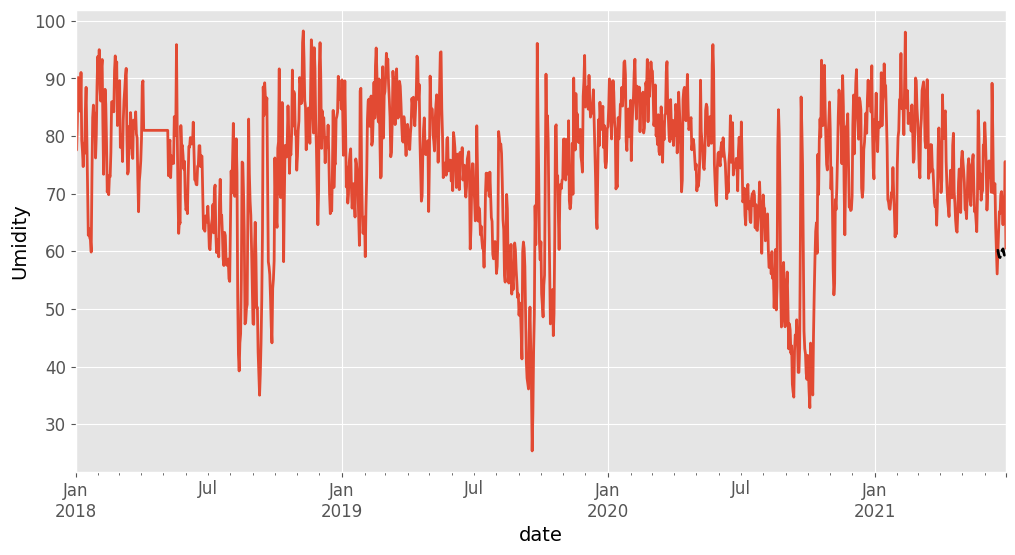

In [126]:
# Train and test split
train_length = int(len(df['Y_t']) * 0.99)
print("Tamanho do teste:", len(df['Y_t'])-train_length)

# model fit
ses_model = ExponentialSmoothing(df['Y_t'][:train_length], seasonal_periods=12, trend='add', seasonal='add')
res = ses_model.fit()

# forecast
forecasts = res.forecast(steps=len(df['Y_t'])-train_length)

# plot
ax = df['Y_t'].plot(figsize=(12, 6))
plt.ylabel('Umidity')
forecasts.plot(style='k--')
plt.show()

In [127]:
from sklearn import metrics
metrics.mean_squared_error(forecasts, df['Y_t'][train_length:], squared=False)

8.082703438829919

In [128]:
metrics.mean_absolute_error(forecasts, df['Y_t'][train_length:])

6.973328663690912

### Holt exponential smoothing

Tamanho do teste: 13


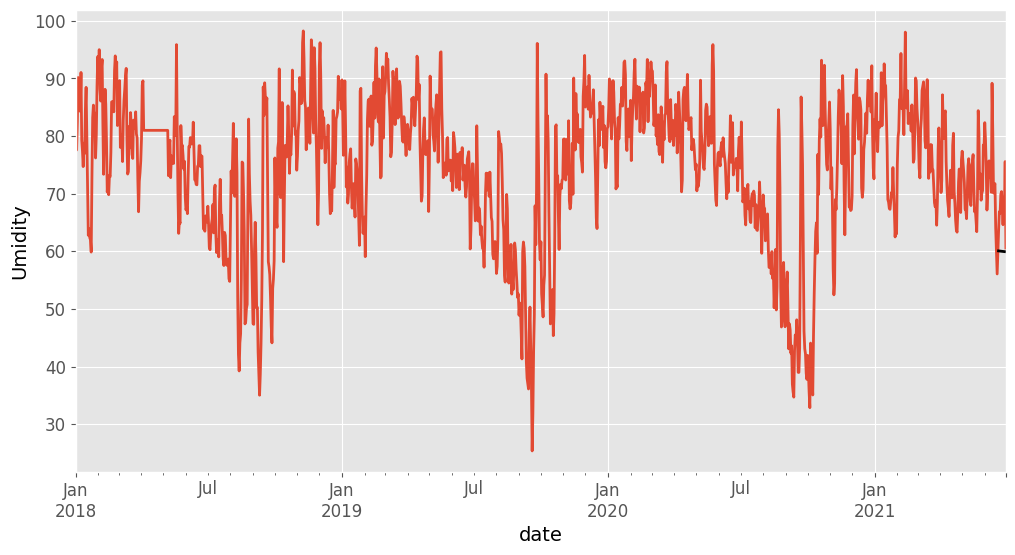

In [129]:
from statsmodels.tsa.api import Holt

# Train and test split
train_length = int(len(df['Y_t']) * 0.99)
print("Tamanho do teste:", len(df['Y_t'])-train_length)

# model fit
ses_model = Holt(df['Y_t'][:train_length])
res = ses_model.fit()

# forecast
forecasts = res.forecast(steps=len(df['Y_t'])-train_length)

# plot
ax = df['Y_t'].plot(figsize=(12, 6))
plt.ylabel('Umidity')
forecasts.plot(style='k--')
plt.show()

In [130]:
metrics.mean_squared_error(forecasts, df['Y_t'][train_length:], squared=False)

7.852546098335523

In [131]:
metrics.mean_absolute_error(forecasts, df['Y_t'][train_length:])

6.7206421259691345

## Modelagem com ARIMA

### Apenas com parâmetro p

$$X_t = \mu + \alpha_{t-1}X_{t-1} + \cdots + \alpha_{t-p}X_{t-p}$$

In [177]:
# ARIMA(3, 1, 3)

# Dividindo conjuntos de treino e teste
train = df.X_t[:1096] # 01-01-2018 até 31-12-2020
test = df.X_t[1096:] # 01-01-2021 até 30-06-2021

# Ajustando parâmetros no conjunto de treino
train_arima313 = ARIMA(train, freq="D", order=(1,0,20)).fit()
train_arima313.params

const     0.029590
ar.L1     0.980490
ma.L1    -0.015363
ma.L2    -0.233983
ma.L3    -0.167509
ma.L4    -0.143801
ma.L5    -0.070329
ma.L6    -0.082690
ma.L7    -0.053954
ma.L8    -0.030411
ma.L9    -0.015143
ma.L10    0.054337
ma.L11    0.031110
ma.L12    0.018065
ma.L13   -0.033419
ma.L14   -0.052110
ma.L15    0.043445
ma.L16    0.036132
ma.L17    0.084406
ma.L18    0.001053
ma.L19    0.006111
ma.L20    0.001306
sigma2    0.211949
dtype: float64

In [179]:
# Calculando predições
test_arima313 = ARIMA(test, freq="D", order=(1,0,20)).fit(train_arima313.params)

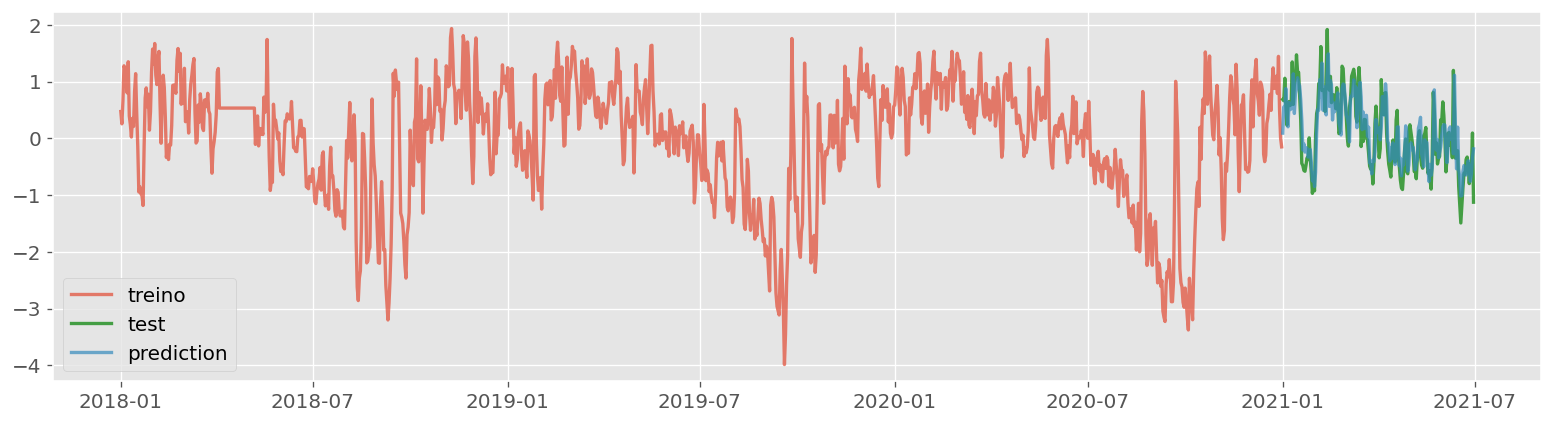

In [180]:
# Visualizando modelagem
pred = test_arima313.predict()
plt.figure(figsize=(16,4))
plt.plot(train.index, train, alpha=0.7, label="treino")
plt.plot(test.index, test, alpha=0.7, color="g", label="test")
plt.plot(pred.index, pred, alpha=0.7, label="prediction")
plt.legend()
plt.show()

In [181]:
# Avaliando o modelo com evs
explained_variance_score(test, pred)

0.6752002119146973

## Modelagem com SARIMAX

In [54]:
# SARIMAX(3, 1, 3)(3,1,3,4)

# Dividindo conjuntos de treino e teste
train = df.X_t[:1096] # 01-01-2018 até 31-12-2020
test = df.X_t[1096:] # 01-01-2021 até 30-06-2021

# Ajustando parâmetros no conjunto de treino
train_sarimax313_31314 = SARIMAX(
    train, freq="D", order=(3,1,3), seasonal_order=(3,1,3,4)).fit()
train_sarimax313_31314.params

ar.L1       0.295144
ar.L2       0.557452
ar.L3      -0.316249
ma.L1      -0.326079
ma.L2      -0.780539
ma.L3       0.221039
ar.S.L4    -1.638749
ar.S.L8    -0.852928
ar.S.L12    0.001803
ma.S.L4     0.671544
ma.S.L8    -0.782423
ma.S.L12   -0.888398
sigma2      0.217745
dtype: float64

In [56]:
# Calculando predições
test_sarimax313_31314 = SARIMAX(
    test, freq="D",order=(3,1,3), seasonal_order=(3,1,3,4)).fit(train_sarimax313_31314.params)

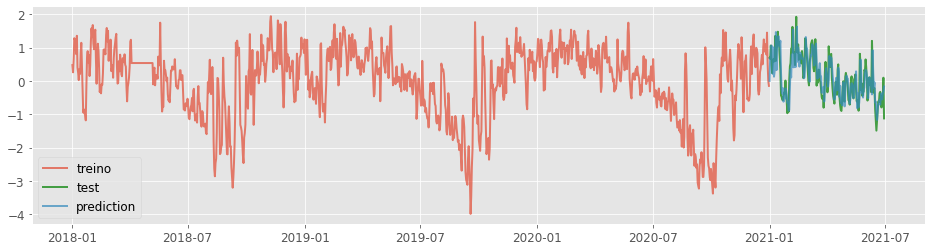

In [57]:
# Visualizando modelagem
pred = test_sarimax313_31314.predict()
plt.figure(figsize=(16,4))
plt.plot(train.index, train, alpha=0.7, label="treino")
plt.plot(test.index, test, alpha=0.7, color="g", label="test")
plt.plot(pred.index, pred, alpha=0.7, label="prediction")
plt.legend()
plt.show()

In [58]:
# Avaliando o modelo com evs
explained_variance_score(test, pred)

0.61847864528183

## Pipeline completo

In [59]:
def prepar_dataframe(path, target, date_column):
    df = pd.read_csv(path)
    df[date_column] = pd.to_datetime(df[date_column])
    df = df[[date_column, target]]
    df = df.fillna(method="ffill")
    df = df[[date_column,target]].groupby(date_column).mean()
    df.columns = ['Y_t']
    df['X_t'] = StandardScaler().fit_transform(df['Y_t'].values.reshape(-1, 1))
    return df

def arima_evs(df, arima_order, train_size):
    train = df.X_t[:train_size]
    test = df.X_t[train_size:]
    train_model = ARIMA(train, freq="D", order=arima_order).fit()
    test_model = ARIMA(test, freq="D", order=arima_order).fit(train_model.params)
    pred_test = test_model.predict()
    evs = explained_variance_score(test, pred_test)
    return evs

def sarimax_evs(df, arima_order, s_order, train_size):
    train = df.X_t[:train_size]
    test = df.X_t[train_size:]
    train_model = SARIMAX(train, freq="D", order=arima_order, seasonal_order=s_order).fit()
    test_model = SARIMAX(
        test, freq="D", order=arima_order, seasonal_order=s_order).fit(train_model.params)
    pred_test = test_model.predict()
    evs = explained_variance_score(test, pred_test)
    return evs

### Preparação dos dados

In [60]:
PATH = "data/df_20181s_20201s_A523.csv"
TARGET = "UMD_INS"
DATE_COLUMN = "date"
prepared_df = prepar_dataframe(PATH, TARGET, DATE_COLUMN)

### ARIMA

In [61]:
ARIMA_ORDER = (3,1,3)
TRAIN_SIZE = 1096
arima_evs(prepared_df, ARIMA_ORDER, TRAIN_SIZE)

0.640103171182913

### SARIMAX

In [62]:
ARIMA_ORDER = (3,1,3)
SARIMAX_ORDER = (3,1,3,4)
TRAIN_SIZE = 1096
sarimax_evs(prepared_df, ARIMA_ORDER, SARIMAX_ORDER, TRAIN_SIZE)

0.61847864528183

### Comparação entre ARIMA's

In [64]:
AR_params = []
I_params = []
MA_params = []
evs = []

for i in range(0,4):
    for j in range(0,4):
        for k in range(0,4):
            ARIMA_ORDER = (i,j,k)
            try:
                score = arima_evs(
                    prepared_df, ARIMA_ORDER, TRAIN_SIZE)
                evs.append(score)
                AR_params.append(i)
                I_params.append(j)
                MA_params.append(k)
            except:
                continue
            
df_results = pd.DataFrame({
    "AR_param": AR_params,
    "I_param": I_params,
    "MA_param": MA_params,
    "evs": evs
})

In [65]:
df_results.sort_values("evs", ascending=False)

,AR_param,I_param,MA_param,evs
51,3,0,3,0.646145
39,2,1,3,0.645151
54,3,1,2,0.642495
55,3,1,3,0.640103
35,2,0,3,0.635633
...,...,...,...,...
60,3,3,0,0.071578
0,0,0,0,0.000000
44,2,3,0,-0.166155
28,1,3,0,-0.492142


## Referências

Tutoriais:
- https://www.youtube.com/watch?v=pxd4ZzROqtI&list=PL5fQ3JoS0SZscDaHgXahtx632NMnq5RR-
- https://www.youtube.com/watch?v=JuGUAvC5qs8&list=PLSDVadsSlXTCVcg95hQsEOVRnVwgaPTRC
- https://datasciencebeginners.com/2020/11/25/time-series-forecast-and-decomposition-101-guide-python/

Bibliotecas:
- https://www.statsmodels.org/
- https://scikit-learn.org/
- https://pandas.pydata.org/
- https://matplotlib.org/

Dados:
- https://tempo.inmet.gov.br/